# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [66]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [67]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

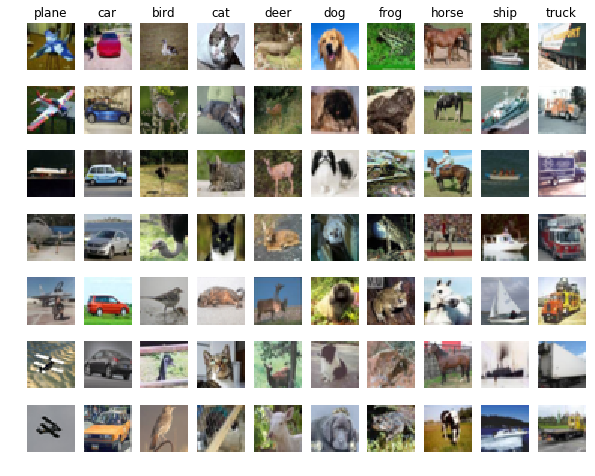

In [68]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ> Большее число слоев. Использование shortcut'ов для борьбы с затуханием градиентов. Использование Batch Normalization. В целом более сложная архитектура большой с глубины с множеством параллельных блоков.

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ> Затухание градиента. Против этого используем residual connections. Также возможно возникновение переобучения. Избежать этого помогает dropout.


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ> Надо бороться с переобучениями. Сложные модели легко запоминают маленькие выборки. В борьбе с этим может помочь Data Augmentation, DropOut, DropConnect, Gradient Clipping, использование регуляризации. Уменьшить размер сети.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ> Звук преобразуется в спектрограмму с помощью преобразования Фурье. Спектрограмма представляет собой двумерное представление 1D-сигнала, поэтому его можно рассматривать как изображение. Или лучше думать о спектрограмме как о изображении 1xT с F-каналами.  Мы не можем просто использовать VGG-19, так как 3x3-свертки не подходят для нашей существенно одномерной задачи, для которой мы наверняка хотим использовать 1D-свертки. Тогда есть два варианта: использовать предварительно настроенную сеть или использовать полностью случайные веса.

In [69]:
import lasagne
import keras 
from theano import tensor as T
from lasagne.nonlinearities import *
from keras.preprocessing.image import ImageDataGenerator
input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [70]:
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as MaxPoolLayer
from lasagne.layers import batch_norm 

def residual_connection(input_layer, n):
    net = batch_norm(ConvLayer(input_layer, n, 3, pad='same'))
    return lasagne.layers.NonlinearityLayer(lasagne.layers.ElemwiseSumLayer(
        [net, batch_norm(ConvLayer(net, n, 3, pad='same')) ]))


net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)
net = residual_connection(net, 32)
net = residual_connection(net, 64)
net = MaxPoolLayer(net, pool_size=2)
net = lasagne.layers.DropoutLayer(net, 0.5)
net = residual_connection(net, 128)
net = MaxPoolLayer(net, pool_size=2)
net = residual_connection(net, 256)
net = MaxPoolLayer(net, pool_size=2)
net = lasagne.layers.DropoutLayer(net, 0.5)
net = batch_norm(lasagne.layers.DenseLayer(net, num_units=512))
net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.DenseLayer(net, num_units=10, nonlinearity=softmax)

In [71]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b]


In [72]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
all_layers = lasagne.layers.get_all_layers(net)
l2_= lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0005
loss = loss + l2_

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

In [73]:
%%capture
lr = 0.001
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.adam(loss, all_weights, learning_rate=sh_lr);
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True);
accuracy_fun = theano.function([input_X,target_y], accuracy, allow_input_downcast=True);


### Вот и всё, пошли её учить

In [74]:
# from https://github.com/Lasagne/Recipes/blob/master/papers/deep_residual_learning/Deep_Residual_Learning_CIFAR-10.py

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            padded = np.pad(inputs[excerpt], ((0, 0), (0, 0), (4, 4), (4, 4)), mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.randint(0, 9, size=(batchsize, 2))
            for r in range(batchsize):
                random_cropped[r, :, :, :] = padded[r, :, crops[r, 0]:(crops[r, 0] + 32), crops[r, 1]:(crops[r, 1] + 32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Процесс обучения

In [75]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 25 #размер мини-батча

for epoch in range(num_epochs):
    if epoch % 10 == 0 and epoch > 0:
        new_lr = sh_lr.get_value() / 2
        print("New learning rate: {:.6f}".format(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_test, y_test, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    

Epoch 0 of 100 took 170.929s
  training loss (in-iteration):		2.878579
  train accuracy:		42.65 %
  validation accuracy:		57.33 %
Epoch 1 of 100 took 170.870s
  training loss (in-iteration):		2.004286
  train accuracy:		59.21 %
  validation accuracy:		63.95 %
Epoch 2 of 100 took 170.931s
  training loss (in-iteration):		1.810606
  train accuracy:		64.10 %
  validation accuracy:		67.91 %
Epoch 3 of 100 took 171.014s
  training loss (in-iteration):		1.711145
  train accuracy:		67.68 %
  validation accuracy:		68.92 %
Epoch 4 of 100 took 171.075s
  training loss (in-iteration):		1.598666
  train accuracy:		70.26 %
  validation accuracy:		71.78 %
Epoch 5 of 100 took 171.222s
  training loss (in-iteration):		1.518781
  train accuracy:		71.95 %
  validation accuracy:		70.84 %
Epoch 6 of 100 took 171.359s
  training loss (in-iteration):		1.458753
  train accuracy:		73.04 %
  validation accuracy:		73.20 %
Epoch 7 of 100 took 171.507s
  training loss (in-iteration):		1.412942
  train accuracy:		

In [79]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		85.43 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 